<a href="https://colab.research.google.com/github/musajalili/band-e-amir-surface-water-monitoring/blob/main/LakeLST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
import xarray as xr
!pip install xee
import xee

In [3]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-jalilimusa',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [6]:
map = geemap.Map(basemap = 'SATELLITE')
map.add_basemap('HYBRID')
map.add_basemap('ROADMAP')
# map

In [7]:
map = geemap.Map(basemap = 'SATELLITE')
# map

In [ ]:
roi = map.draw_last_feature.geometry()

roi

In [ ]:
def oli(img):
  qa = img.select('QA_PIXEL')
  cloud = qa.bitwiseAnd(1 << 1).neq(0)
  cirrus = qa.bitwiseAnd(2 << 1).neq(0)
  cloud2 = qa.bitwiseAnd(3 << 1).neq(0)
  shadow = qa.bitwiseAnd(4 << 1).neq(0)
  cloud_mask = cloud.Or(cirrus).Or(cloud2).Or(shadow)
  ms = img.select('SR_B.*').multiply(2.75e-05).add(-0.2)
  ndwi = ms.normalizedDifference(['SR_B3', 'SR_B5']).rename('ndwi')
  water_mask = ndwi.gt(0.1)
  lst = img.select('ST_B10').multiply(0.00341802).add(149)
  return lst.updateMask(water_mask).updateMask(cloud_mask.Not()).copyProperties(img, ['system:time_start'])


l8 = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate('2024','2025')
    .filterBounds(roi)
    .map(oli)

)

l9 = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate('2024', '2025')
    .filterBounds(roi)
    .map(oli)

)

collection = l8.merge(l9).sort('system:time_start')

collection

In [ ]:
ds = xr.open_dataset(
    collection,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.0003,
    geometry = roi
)

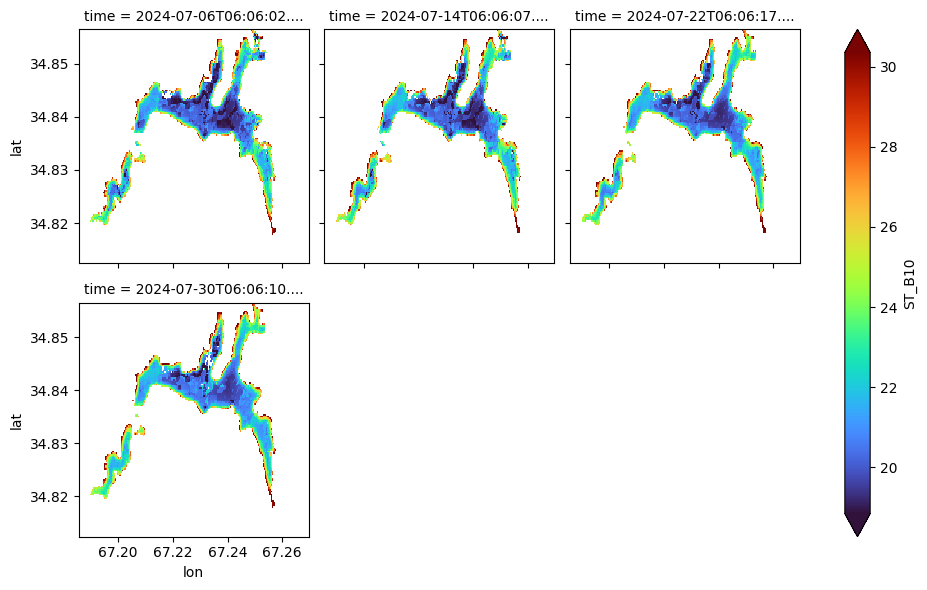

In [ ]:
ds = ds.sortby('time') - 273.15

ds_roll = ds.rolling(time = 7, center = True, min_periods = 1).mean('time')

import matplotlib.pyplot as plt

ds_roll.sel(time = ds.time.dt.month == 7).ST_B10.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 3,
    robust = True,
    cmap = 'turbo'
)

<Figure size 640x480 with 0 Axes>

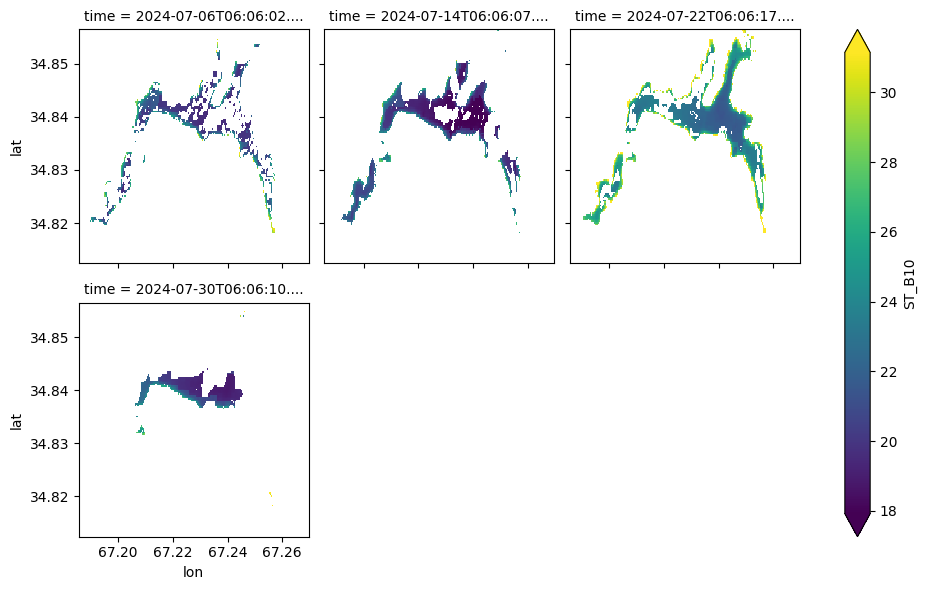

In [ ]:
plt.savefig('water_temp.png', dpi = 360, bbox_inches = 'tight')

ds.sel(time = ds.time.dt.month == 7).ST_B10.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 3,
    robust = True
)

<Axes: xlabel='time'>

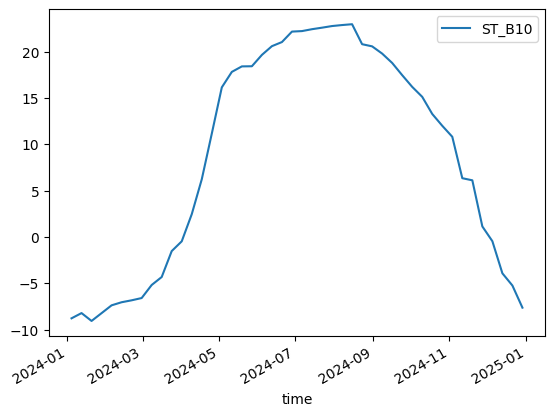

In [ ]:
ds_mean = ds_roll.mean(['lon', 'lat']).to_dataframe()
ds_mean.plot()